In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.models import Sequential
from imblearn.over_sampling import RandomOverSampler
import string
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
exclude = string.punctuation
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
base_path = "/content/drive/MyDrive/Political Bias Detection in News Articles Analysis"

In [ ]:
data = pd.read_csv(f"{base_path}/Political_Bias.csv")

In [ ]:
data['Text'] = data['Text'].fillna('')
data['Text'] = data['Text'].str.replace('â€™', "'", regex=False)

In [ ]:
error_rows = data[data['Text'] == 'Error fetching article']
error_rows['Text'] = error_rows['Title']
df = pd.concat([data, error_rows], ignore_index=True)
error_rows = data[data['Text'] == 'Error fetching article']
error_rows['Text'] = error_rows['Title']
df = pd.concat([data, error_rows], ignore_index=True)
df.drop_duplicates(subset=['Title'], keep="last",inplace=True)

<ipython-input-151-90d016dde2b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_rows['Text'] = error_rows['Title']
<ipython-input-151-90d016dde2b1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_rows['Text'] = error_rows['Title']


In [ ]:
df = df[df['Text'].notna() & (df['Text'] != "")]

In [ ]:
df.head()

,Title,Link,Text,Source,Bias
0,John Boltonâ€™s Advice for the â€˜Continuing T...,https://thedispatch.com/article/john-boltons-a...,"With just days until his inauguration, it woul...",TheDispatch,lean right
1,Why Shrubland Makes Southern Californiaâ€™s Wi...,https://thedispatch.com/newsletter/techne/why-...,"Welcome back to Techne! In Star Trek, writers ...",TheDispatch,lean right
2,Los Angelesâ€™ Destruction Was Fueled by Bad P...,https://thedispatch.com/newsletter/capitolism/...,"As fire still rages in the Los Angeles area, I...",TheDispatch,lean right
3,Acquiring Greenland Is a Good Idea. Threatenin...,https://thedispatch.com/article/acquiring-gree...,"Whether it was Will Rogers or Tony Soprano, th...",TheDispatch,lean right
4,Assessing Trumpâ€™s Expansionist Designs,https://thedispatch.com/newsletter/morning/ass...,"Happy Friday! If anyone was wondering, Belgium...",TheDispatch,lean right


In [ ]:
X = df['Text']

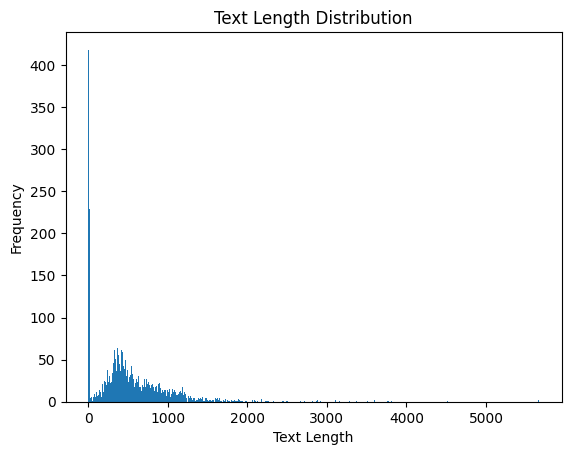

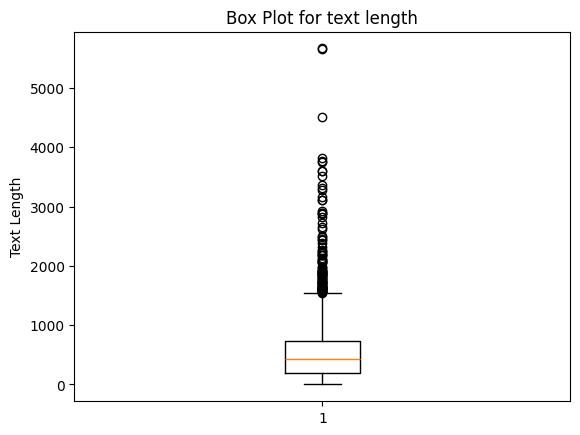

In [ ]:
import matplotlib.pyplot as plt
import os

os.makedirs(os.path.join(base_path, "images"), exist_ok=True)
fig_path = os.path.join(base_path, "images")


lengths = [len(text.split()) for text in X]
plt.hist(lengths, bins=500)
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Text Length Distribution")
plt.savefig(f"{fig_path}/TextLength_Frequency_Distribution")
plt.show()


import matplotlib.pyplot as plt
lengths = [len(text.split()) for text in X]
plt.boxplot(lengths)
plt.ylabel("Text Length")
plt.title("Box Plot for text length")
plt.savefig(f"{fig_path}/BoxPlot_for_text_length")
plt.show()

In [ ]:
def simplify_bias(label):
    if label in ['left', 'lean left']:
        return 'left'
    elif label == 'center':
        return 'center'
    else:  # 'right' or 'lean right'
        return 'right'

df['Simplified_Bias'] = df['Bias'].apply(simplify_bias)

In [ ]:
df['Simplified_Bias'].value_counts()

,count
Simplified_Bias,
left,2256
right,635
center,258


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Simplified_Bias'])

In [ ]:
label_encoder.classes_

array(['center', 'left', 'right'], dtype=object)

In [ ]:
def load_glove_embeddings(glove_path, word_index, embedding_dim=100):
    """
      GloVe Embeddings maker: It takes the word index and uses glove 6B 100 dimensions corpus to generate embeddings!

      Args:
        glove_path (string): path to the glove file
        word_index (dictionary): word indexes generated after tokenization
        embedding_dimensions (int): in this case 100 as we use 100 dimensions corpus

      Returns
        (array(array(float))): Generated Embeddings
    """
    embeddings_index = {}

    with open(glove_path, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]  # Word
            vector = np.asarray(values[1:], dtype="float32")  # Embedding vector
            embeddings_index[word] = vector

    # Create embedding matrix
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  # Words found in GloVe

    return embedding_matrix

In [ ]:
# HELPER FUNCTIONS
import re

def remove_stopwords(text):
  new_text = []
  for word in text.split():
    if word not in stop_words:
      new_text.append(word)
  return " ".join(new_text)

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

def remove_urls(text):
    text = re.sub(r'http\S+|www.\S+', '', text)
    return text

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def clean_text(X, max_sequence_length=100):
  """
    Text cleaner: It does stemming, tokenization and embedding generation of the data
    Args:
      X (array(str)): Articles
      y (array(int)): Categories of articles
      max_sequence_length (int): Max length of sequence

    Returns:
      X_resampled, y_resampled, embedding_matrix, tokenizer
  """

  lower_text_X = [text.lower() for text in X]
  lower_text_X = [remove_urls(text) for text in lower_text_X]
  lower_text_X = [remove_numbers(text) for text in lower_text_X]

  no_punc_text_X = [remove_punc(text) for text in lower_text_X]

  stop_word_clean_text_X = [remove_stopwords(word) for word in no_punc_text_X]

  stemmer = PorterStemmer()
  stemmed_text = [" ".join([stemmer.stem(word) for word in sentence.split()]) for sentence in stop_word_clean_text_X]

  # lemmatizer = WordNetLemmatizer()
  # stemmed_text = [" ".join([lemmatizer.lemmatize(word) for word in sentence.split()]) for sentence in stemmed_text]

  tokenizer = Tokenizer(
      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\tâ€\n',
      oov_token="<OOV>",
      lower=True,
      num_words=30000)
  tokenizer.fit_on_texts(stemmed_text)

  sequences = tokenizer.texts_to_sequences(stemmed_text)
  padded_sequences = pad_sequences(sequences, padding= "post",maxlen=max_sequence_length)

  word_index = tokenizer.word_index
  glove_path = "/content/drive/MyDrive/Major Project/glove.6B.100d.txt"
  embedding_matrix = load_glove_embeddings(glove_path=glove_path, word_index=word_index)

  return padded_sequences, embedding_matrix, tokenizer


In [ ]:
X_padded, embedding_matrix, tokenizer= clean_text(X, max_sequence_length=350)

In [ ]:
# MODEL MAKER FUNCTIONS
# MAX_FEATURES = 39913
# LSTM MODEL FUNCTION
# MAX_FEATURES = 46042
# MAX_FEATURES = 37909
MAX_FEATURES = 37982
def model_maker_LSTM(embedding_matrix, max_features=MAX_FEATURES, op_layer=3, embedding_dim=100):
  model = Sequential()

  model.add(Embedding(input_dim=max_features,
                      output_dim=embedding_dim,
                      weights=[embedding_matrix],
                      trainable=True))

  # LSTM Layer
  model.add(Bidirectional(LSTM(128, activation="tanh", return_sequences=True)))
  model.add(Dropout(0.2))  # Prevent overfitting
  model.add(Bidirectional(LSTM(64, activation="tanh")))
  # Batch Normalization
  model.add(BatchNormalization())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.3))
  # Output Layer (Softmax for multi-class classification)
  model.add(Dense(op_layer, activation="softmax"))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

# GRU MODEL FUNCTION
def model_maker_GRU(embedding_matrix, max_features=MAX_FEATURES, op_layer=3, embedding_dim=100):
  model = Sequential()

  model.add(Embedding(input_dim=max_features,
                      output_dim=embedding_dim,
                      weights=[embedding_matrix],
                      trainable=True))

  # GRU Layer
  model.add(Bidirectional(GRU(128, activation="tanh", return_sequences=True)))
  model.add(Dropout(0.2))  # Prevent overfitting
  model.add(Bidirectional(GRU(64, activation="tanh")))
  # Batch Normalization
  model.add(BatchNormalization())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.3))
  # Output Layer (Softmax for multi-class classification)
  model.add(Dense(op_layer, activation="softmax"))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

# HYBRID MODEL FUNCTION
def model_maker_hybrid(embedding_matrix, max_features=MAX_FEATURES, op_layer=3, embedding_dim=100):
  model = Sequential()

  model.add(Embedding(input_dim=max_features,
                      output_dim=embedding_dim,
                      weights=[embedding_matrix],
                      trainable=True))

  # LSTM Layer
  model.add(Bidirectional(LSTM(128, activation="tanh", return_sequences=True)))
  model.add(Dropout(0.2))  # Prevent overfitting
  # GRU Layer
  model.add(Bidirectional(GRU(64, activation="tanh")))
  # Batch Normalization
  model.add(BatchNormalization())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  # Output Layer (Softmax for multi-class classification)
  model.add(Dense(op_layer, activation="softmax"))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
def create_models(embedding_matrix):
  models = {}
  models["model_lstm"] = model_maker_LSTM(embedding_matrix=embedding_matrix)
  models["model_gru"] = model_maker_GRU(embedding_matrix=embedding_matrix)
  models["model_hybrid"] = model_maker_hybrid(embedding_matrix=embedding_matrix)
  return models

In [ ]:
models = create_models(embedding_matrix=embedding_matrix)

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def create_split_and_resampling(X, y):
  print("Creating Split...")
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
  X_train = np.array(X_train)
  y_train = np.array(y_train)

  print("Resampling Training Split...")
  ros = RandomOverSampler(random_state=42)
  X_res, y_res = ros.fit_resample(X_train, y_train)

  # unique, counts = np.unique(y_res, return_counts=True)
  y_res = to_categorical(y_res, num_classes=3)
  # print(f"Values resampled by {counts}")
  print("Split Created!")
  return X_res, y_res, X_test, y_test


In [ ]:
X_train, y_train, X_test, y_test = create_split_and_resampling(X=X_padded, y=y)

Creating Split...
Resampling Training Split...
Split Created!


In [ ]:
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)

class_weights_dict = dict(enumerate(class_weights))


def model_training(models, early_stopping, train_model="all", class_weights_dict=None):

  history = {}
  for model_name, model in models.items():
    if model_name in train_model or train_model == "all":
      print("="*50)
      print(f"Training {model_name}...")
      history[model_name] = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=16,
        validation_split=0.2,
        class_weight = class_weights_dict,
        callbacks=[early_stopping],
      )
      print(f"{model_name} trained successfully!")
  print("MODEL(s) TRAINED SUCCESSFULLY")

  return history

In [ ]:
history = model_training(models, early_stopping, train_model="all", class_weights_dict=class_weights_dict)

Training model_lstm...
Epoch 1/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.4310 - loss: 1.7805 - val_accuracy: 0.2392 - val_loss: 1.0478
Epoch 2/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - accuracy: 0.6113 - loss: 0.8023 - val_accuracy: 0.8744 - val_loss: 0.5685
Epoch 3/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.7298 - loss: 0.4461 - val_accuracy: 0.9760 - val_loss: 0.2033
Epoch 4/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.8290 - loss: 0.2793 - val_accuracy: 0.9658 - val_loss: 0.2107
Epoch 5/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.8519 - loss: 0.2648 - val_accuracy: 0.9917 - val_loss: 0.0516
Epoch 6/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.8902 - loss: 0.2430 - val_accuracy: 0.9825 - val_loss: 0.0451
Epoch 7/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.9508 - loss: 0.1010 - val_accuracy: 0.9880 - val_loss: 0.0442
Epoch 8/50
271/271 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0

In [ ]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score

def evaluate_models():
  predictions = {}

  for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    y_pred = model.predict(X_test)
    predictions[model_name] = y_pred
    y_pred_labels = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_test, y_pred_labels)
    print(f"Test Accuracy: {accuracy:.2%}")
    print("="*25)

  ensemble_pred = {}
  # SOFT VOTING
  y_pred_soft_voting = np.mean([predictions[model_name] for model_name in predictions], axis=0)
  y_pred_soft_voting_labels = np.argmax(y_pred_soft_voting, axis=1)
  ensemble_pred['soft_voting'] = y_pred_soft_voting_labels

  # HARD VOTNG
  y_pred_hard_voting = np.vstack([np.argmax(predictions[model_name], axis=1) for model_name in predictions])
  y_pred_hard_voting_labels = mode(y_pred_hard_voting, axis=0)[0].flatten()
  ensemble_pred['hard_voting'] = y_pred_hard_voting_labels

  print(f"SOFT VOTING: {accuracy_score(y_test, y_pred_soft_voting_labels)}")
  print(f"HARD VOTING: {accuracy_score(y_test, y_pred_hard_voting_labels)}")

  return predictions, ensemble_pred

In [ ]:
# SCRIPT FOR SAVING IMPORTANT MODEL
def save_models(models):
    try:
        with open("/content/drive/MyDrive/Political Bias Detection in News Articles Analysis/models/current_model_count.txt", "r") as file:
            pol_model_count = int(file.read())
    except FileNotFoundError:
        pol_model_count = 0

    pol_model_count += 1

    for model_name, model in models.items():
        model.save(f"/content/drive/MyDrive/Political Bias Detection in News Articles Analysis/models/test_{pol_model_count}/model_pol_{model_name}_{pol_model_count}.keras")

    np.save(f"/content/drive/MyDrive/Political Bias Detection in News Articles Analysis/models/test_{pol_model_count}/embedding_matrix_pol_{pol_model_count}.npy", embedding_matrix)

    with open(f"/content/drive/MyDrive/Political Bias Detection in News Articles Analysis/models/test_{pol_model_count}/tokenizer_pol_{pol_model_count}.pkl", "wb") as f:
      pickle.dump(tokenizer, f)

    with open("/content/drive/MyDrive/Political Bias Detection in News Articles Analysis/models/current_model_count.txt", "w") as file:
        file.write(str(pol_model_count))


In [ ]:
try:
    with open("/content/drive/MyDrive/Political Bias Detection in News Articles Analysis/models/current_model_count.txt", "r") as file:
        pol_model_count = int(file.read())
except FileNotFoundError:
        pol_model_count = 0
pol_model_count += 1

In [ ]:
import pickle
import os

os.makedirs(f"/content/drive/MyDrive/Political Bias Detection in News Articles Analysis/models/test_{pol_model_count}", exist_ok=True)
predictions, ensemble_pred = evaluate_models()
with open(f"/content/drive/MyDrive/Political Bias Detection in News Articles Analysis/models/test_{pol_model_count}/predictions_{pol_model_count}.pkl", "wb+") as f:
  pickle.dump(predictions, f)

with open(f"/content/drive/MyDrive/Political Bias Detection in News Articles Analysis/models/test_{pol_model_count}/ensemble_{pol_model_count}.pkl", "wb+") as f:
  pickle.dump(ensemble_pred, f)

Evaluating model_lstm...
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Test Accuracy: 73.33%
Evaluating model_gru...
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Test Accuracy: 79.52%
Evaluating model_hybrid...
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Test Accuracy: 77.14%
SOFT VOTING: 0.7841269841269841
HARD VOTING: 0.780952380952381


In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(predictions, ensemble_pred, y_test, pol_model_count, save_fig=True):
    base_path = "/content/drive/MyDrive/Political Bias Detection in News Articles Analysis/models"
    cm_dir = os.path.join(base_path, f"test_{pol_model_count}", "confusion_matrices")
    os.makedirs(cm_dir, exist_ok=True)

    for model, prediction in predictions.items():
        # print(f"Confusion Matrix: {model}")
        y_pred_labels = np.argmax(prediction, axis=1)
        cm = confusion_matrix(y_test, y_pred_labels)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=['center', 'left', 'right'],
                    yticklabels=['center', 'left', 'right'])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"{model} Confusion Matrix")
        plt.tight_layout()
        if save_fig:
          plt.savefig(os.path.join(cm_dir, f"{model}_cm.png"))
        plt.show()
        plt.close()

    for method, prediction in ensemble_pred.items():
        # print(f"Confusion Matrix: {method}")
        cm = confusion_matrix(y_test, prediction)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["center", "left", "right"],
                    yticklabels=["center", "left", "right"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"{method} Confusion Matrix")
        plt.tight_layout()
        if save_fig :
          plt.savefig(os.path.join(cm_dir, f"{method}_cm.png"))
        plt.show()
        plt.close()

def print_metrics(predictions, ensemble_pred, y_test, pol_model_count):
    base_path = "/content/drive/MyDrive/Political Bias Detection in News Articles Analysis/models"
    metrics_path = os.path.join(base_path, f"test_{pol_model_count}", "metrics.txt")
    os.makedirs(os.path.dirname(metrics_path), exist_ok=True)

    with open(metrics_path, "w") as f:
        for model, prediction in predictions.items():
            y_pred_labels = np.argmax(prediction, axis=1)
            report = classification_report(y_test, y_pred_labels, target_names=["center", "left", "right"])
            print(f"Metrics: {model}")
            print("=" * 25)
            print(report)
            f.write(f"Metrics: {model}\n")
            f.write("=" * 25 + "\n")
            f.write(report + "\n\n")

        for method, prediction in ensemble_pred.items():
            report = classification_report(y_test, prediction, target_names=["center", "left", "right"])
            print(f"Metrics: {method}")
            print("=" * 25)
            print(report)
            f.write(f"Metrics: {method}\n")
            f.write("=" * 25 + "\n")
            f.write(report + "\n\n")

In [ ]:
save_models(models)

Metrics: model_lstm
              precision    recall  f1-score   support

        left       0.69      0.48      0.57        52
      center       0.88      0.74      0.81       451
       right       0.48      0.81      0.60       127

    accuracy                           0.73       630
   macro avg       0.68      0.68      0.66       630
weighted avg       0.79      0.73      0.74       630

Metrics: model_gru
              precision    recall  f1-score   support

        left       0.62      0.46      0.53        52
      center       0.87      0.86      0.86       451
       right       0.62      0.72      0.66       127

    accuracy                           0.80       630
   macro avg       0.70      0.68      0.68       630
weighted avg       0.80      0.80      0.79       630

Metrics: model_hybrid
              precision    recall  f1-score   support

        left       0.52      0.48      0.50        52
      center       0.88      0.82      0.85       451
       right  

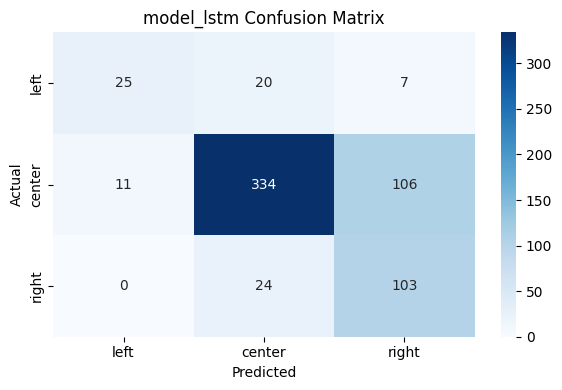

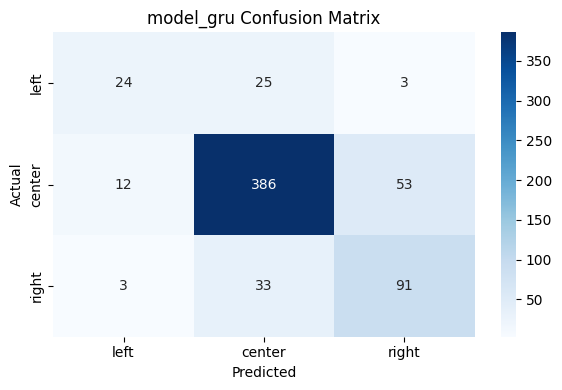

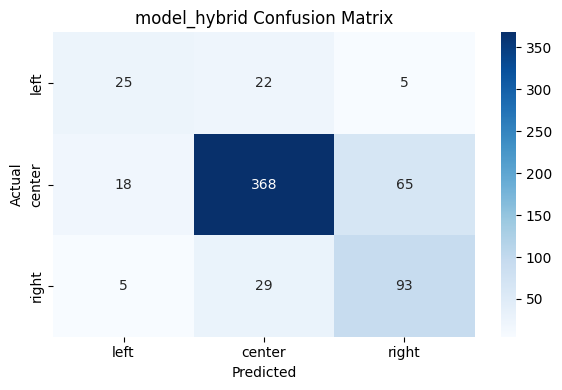

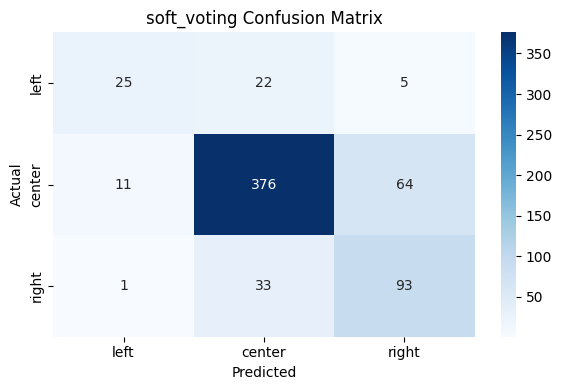

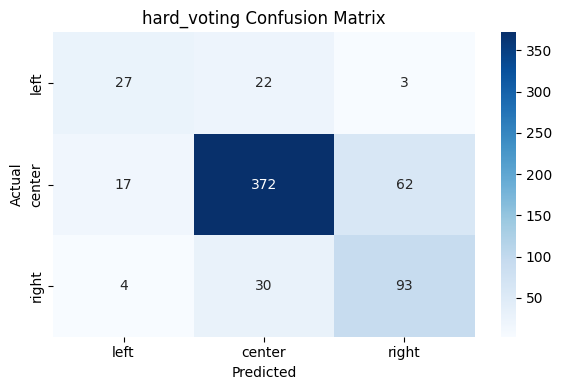

In [ ]:
print_metrics(y_test=y_test, pol_model_count=pol_model_count, predictions=predictions, ensemble_pred=ensemble_pred)
print_confusion_matrix(y_test=y_test, pol_model_count=pol_model_count, predictions=predictions, ensemble_pred=ensemble_pred)

In [ ]:
INFO_PATH = os.path.join(base_path, f"models/test_{pol_model_count}", "info.txt")
with open(f"{INFO_PATH}", "w+") as f:
  f.write(f"{pol_model_count} : TEST")
  f.write("LOWERED BATCH SIZE 32 -> 16\n")
  f.write("USED CLASSWEIGHTS INSTED OF ROS\n")

- 1st record (ONLY STEMMING AND TOKENIZATION): 0.6370716510903427
- 2nd record (NO PUNC, STEMMING AND TOKENIZATION): 0.6479750778816199
- 3rd record (+ REMOVING STOP WORDS): 0.6806853582554517
- 4th record (+Random Over Sampling): 0.9086


AFTER CORRECTING PIPELINE
- 1st record: 0.75
- 2nd record: 0.8492063492063492


# Model Performance Evaluation

## Key Metrics:
- **Accuracy**: 90.86%  
  The model correctly predicted the class 90.86% of the time.

- **Precision (Weighted)**: 90.95%  
  When the model predicted a positive class, it was correct 90.95% of the time.

- **Recall (Weighted)**: 90.86%  
  The model successfully identified 90.86% of all actual positive instances across all classes.

- **F1-score (Weighted)**: 90.69%  
  The F1-score, balancing precision and recall, is 90.69%, indicating a strong trade-off between these metrics.

## Per-Class Breakdown:
| Class        | Precision | Recall | F1-score | Support |
|--------------|-----------|--------|----------|---------|
| **Left**     | 89%       | 77%    | 82%      | 364     |
| **Lean Left**| 91%       | 85%    | 88%      | 358     |
| **Center**   | 85%       | 100%   | 92%      | 331     |
| **Lean Right**| 97%      | 98%    | 97%      | 340     |
| **Right**    | 93%       | 96%    | 94%      | 358     |

## Accuracy and Averages:
- **Overall Accuracy**: 90.86%
- **Macro Average**:  
  - Precision: 91%  
  - Recall: 91%  
  - F1-score: 91%

- **Weighted Average**:  
  - Precision: 91%  
  - Recall: 91%  
  - F1-score: 91%

## Summary:
- **Strongest Class**: The model performs exceptionally well on the **"Lean Right"** and **"Right"** classes, achieving nearly perfect precision and recall (97% and 98% respectively).
- **Center Class**: The model achieves perfect recall for the **"Center"** class (100%), although it slightly sacrifices precision (85%).
- **Left Class**: The **"Left"** class shows room for improvement in recall, as only 77% of the actual instances were correctly identified.
- **Lean Left Class**: While **"Lean Left"** has solid precision (91%), recall (85%), and F1-score (88%), it could benefit from slight improvements in both.

Overall, the model performs excellently with room for minor adjustments to enhance the recall of the **"Left"** class and improve precision for **"Center"** if needed.


# METRICS ANALYSIS

In [ ]:
# DEFINING MODEL METRICS FROM THE BEST MODEL SO FAR
from tensorflow import keras

model_lstm = keras.models.load_model("/content/drive/MyDrive/Political Bias Detection in News Articles Analysis/models/test_6/model_pol_model_lstm_6.keras")
model_gru = keras.models.load_model("/content/drive/MyDrive/Political Bias Detection in News Articles Analysis/models/test_6/model_pol_model_gru_6.keras")
model_hybrid = keras.models.load_model("/content/drive/MyDrive/Political Bias Detection in News Articles Analysis/models/test_6/model_pol_model_hybrid_6.keras")

models = {
    "model_lstm": model_lstm,
    "model_gru": model_gru,
    "model_hybrid": model_hybrid
}

In [ ]:

# HELPER FUNCTIONS
import re

def clean_text(X, max_sequence_length=100):
  """
    Text cleaner: It does stemming, tokenization and embedding generation of the data
    Args:
      X (array(str)): Articles
      y (array(int)): Categories of articles
      max_sequence_length (int): Max length of sequence

    Returns:
      X_resampled, y_resampled, embedding_matrix, tokenizer
  """

  lower_text_X = [text.lower() for text in X]
  lower_text_X = [remove_urls(text) for text in lower_text_X]
  lower_text_X = [remove_numbers(text) for text in lower_text_X]

  no_punc_text_X = [remove_punc(text) for text in X]

  stop_word_clean_text_X = [remove_stopwords(word) for word in no_punc_text_X]

  stemmer = PorterStemmer()
  stemmed_text = [" ".join([stemmer.stem(word) for word in sentence.split()]) for sentence in stop_word_clean_text_X]

  # lemmatizer = WordNetLemmatizer()
  # stemmed_text = [" ".join([lemmatizer.lemmatize(word) for word in sentence.split()]) for sentence in stemmed_text]
  with open(f"{base_path}/models/test_6/tokenizer_pol_6.pkl", "rb") as f:
    tokenizer = pickle.load(f)
  # tokenizer.fit_on_texts(stemmed_text)

  sequences = tokenizer.texts_to_sequences(stemmed_text)
  padded_sequences = pad_sequences(sequences, padding= "pre",maxlen=max_sequence_length)

  return padded_sequences


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_padded = clean_text(X_test, max_sequence_length=400)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import mode
import pickle

def pred_pipeline(models, X_test, y):
    predictions = {}
    for model_name, model in models.items():
      print(f"Evaluating {model_name}...")
      y_pred = model.predict(X_test)
      predictions[model_name] = y_pred
      y_pred_labels = np.argmax(y_pred, axis=1)
      print(classification_report(y, y_pred_labels))
      print("="*25)

    ensemble_pred = {}
    # SOFT VOTING
    y_pred_soft_voting = np.mean([predictions[model_name] for model_name in predictions], axis=0)
    y_pred_soft_voting_labels = np.argmax(y_pred_soft_voting, axis=1)
    ensemble_pred['soft_voting'] = y_pred_soft_voting_labels

    # HARD VOTNG
    y_pred_hard_voting = np.vstack([np.argmax(predictions[model_name], axis=1) for model_name in predictions])
    y_pred_hard_voting_labels = mode(y_pred_hard_voting, axis=0)[0].flatten()
    ensemble_pred['hard_voting'] = y_pred_hard_voting_labels

    print(f"SOFT VOTING: {classification_report(y, y_pred_soft_voting_labels)}")
    print(f"HARD VOTING: {classification_report(y, y_pred_hard_voting_labels)}")


    return predictions, ensemble_pred

['center', 'left', 'right'] -> [0, 1, 2]

In [ ]:
prediction, ensemble_pred = pred_pipeline(models, X_padded, y_test)

Evaluating model_lstm...
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 701ms/step
              precision    recall  f1-score   support

           0       0.58      0.62      0.60        52
           1       0.91      0.88      0.90       451
           2       0.71      0.76      0.73       127

    accuracy                           0.84       630
   macro avg       0.73      0.75      0.74       630
weighted avg       0.84      0.84      0.84       630

Evaluating model_gru...
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 328ms/step
              precision    recall  f1-score   support

           0       0.76      0.60      0.67        52
           1       0.94      0.76      0.84       451
           2       0.50      0.89      0.64       127

    accuracy                           0.77       630
   macro avg       0.73      0.75      0.72       630
weighted avg       0.83      0.77      0.78       630

Evaluating model_hybrid...
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
              precision    recall  f1-sc

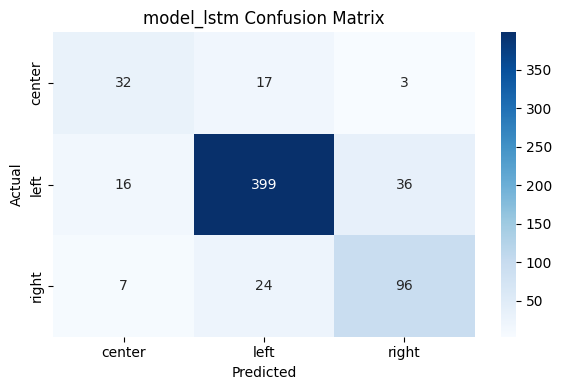

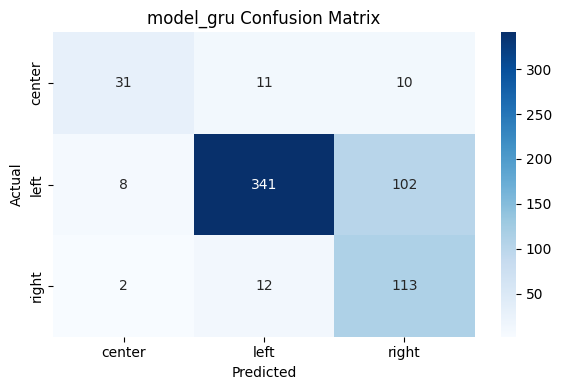

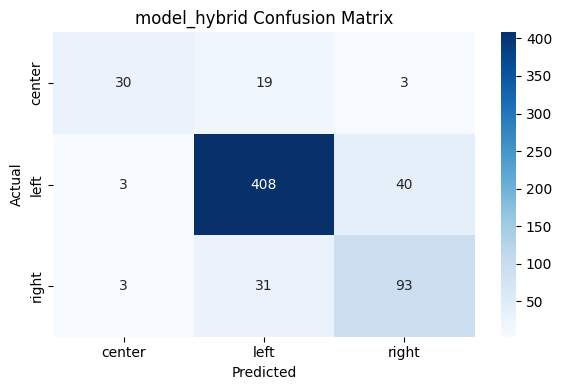

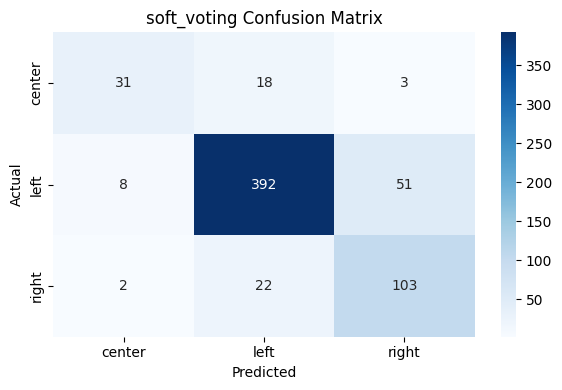

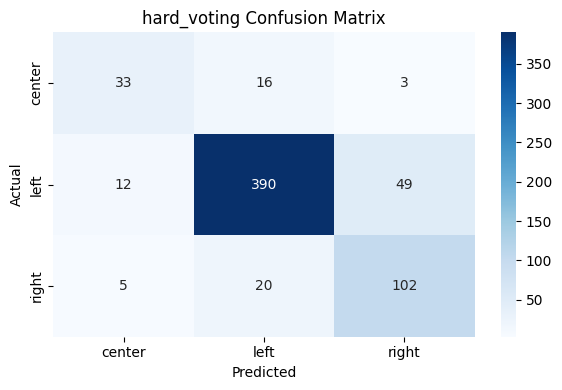

In [ ]:
print_confusion_matrix(y_test=y_test, pol_model_count=6, predictions=prediction, ensemble_pred=ensemble_pred, save_fig=True)

In [ ]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

def plot_roc_curve(y_true, y_pred_prob, n_classes=3, title="ROC Curve - Soft Voting Ensemble", save_fig=True):

    # Class labels for your specific case
    classes = {
        0: "Center",
        1: "Left",
        2: "Right"
    }

    # Step 1: Binarize the labels
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    # Step 2: Compute ROC and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Step 3: Plot
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'green', 'red']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot(fpr["macro"], tpr["macro"], color='black', linestyle='--', label=f"Macro Avg (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()


    if save_fig:
        metric_dir = os.path.join(base_path, "models/test_6/metric_curves")
        os.makedirs(metric_dir, exist_ok=True)

        plt.savefig(os.path.join(metric_dir, f"{title}_roc_curve.png"))
        print(f"ROC curve saved to {metric_dir}/roc_curve.png")

    plt.show()

ROC curve saved to /content/drive/MyDrive/Political Bias Detection in News Articles Analysis/models/test_6/metric_curves/roc_curve.png


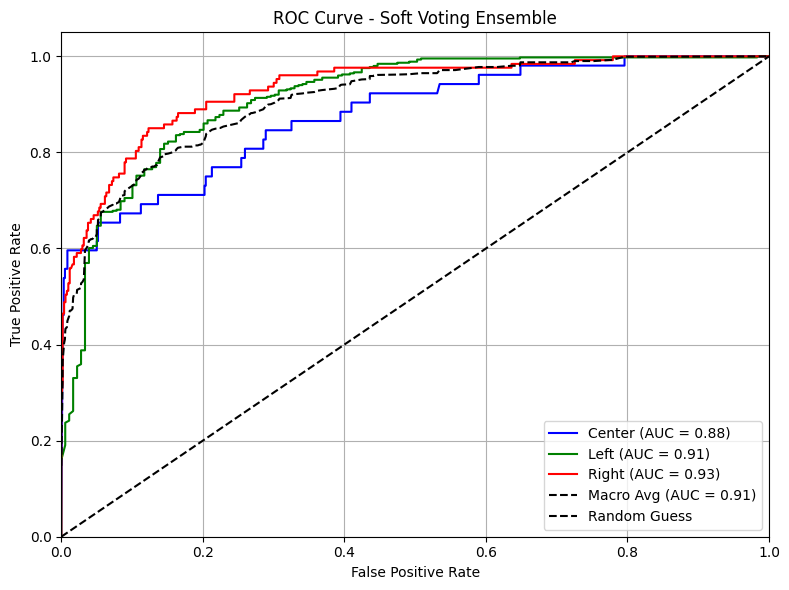

In [ ]:
# Average the predicted probabilities across the models
y_pred_soft_probs = np.mean([prediction[m] for m in prediction], axis=0)

# Now, plot the ROC curve using those averaged probabilities
plot_roc_curve(y_test, y_pred_soft_probs)


ROC curve saved to /content/drive/MyDrive/Political Bias Detection in News Articles Analysis/models/test_6/metric_curves/roc_curve.png


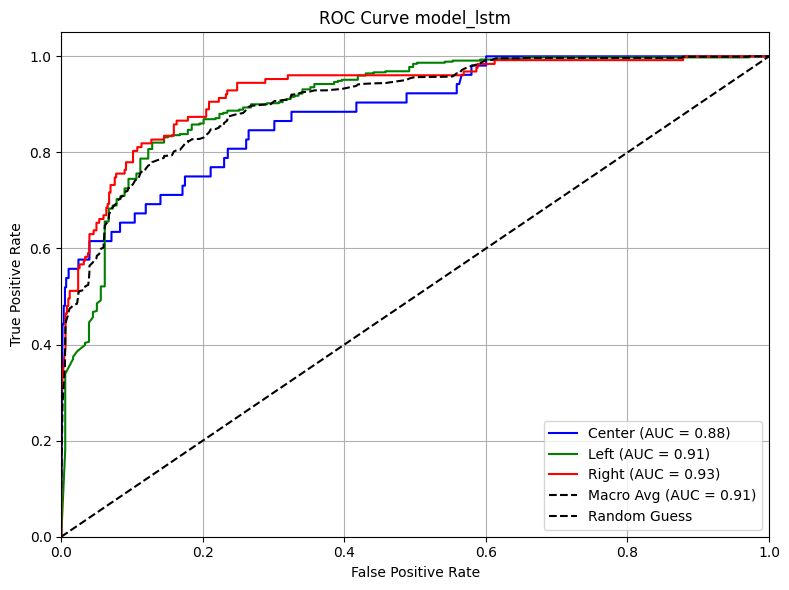

ROC curve saved to /content/drive/MyDrive/Political Bias Detection in News Articles Analysis/models/test_6/metric_curves/roc_curve.png


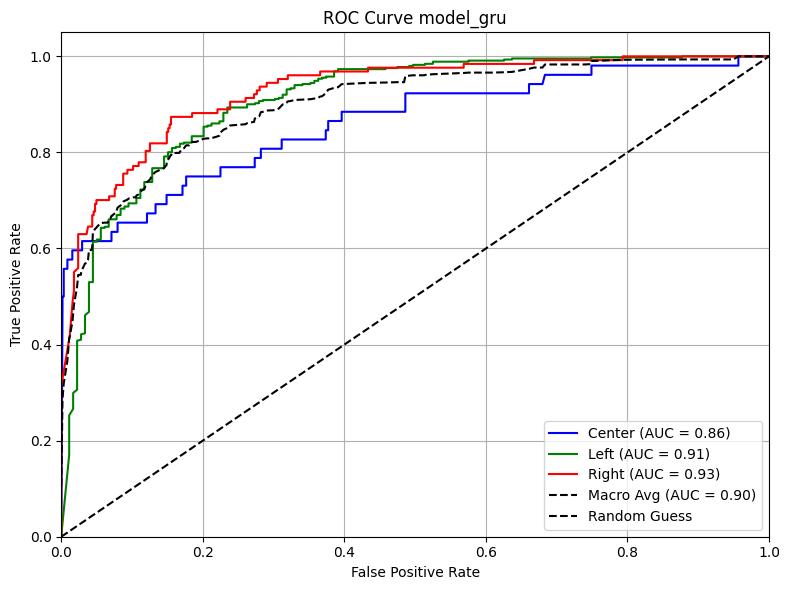

ROC curve saved to /content/drive/MyDrive/Political Bias Detection in News Articles Analysis/models/test_6/metric_curves/roc_curve.png


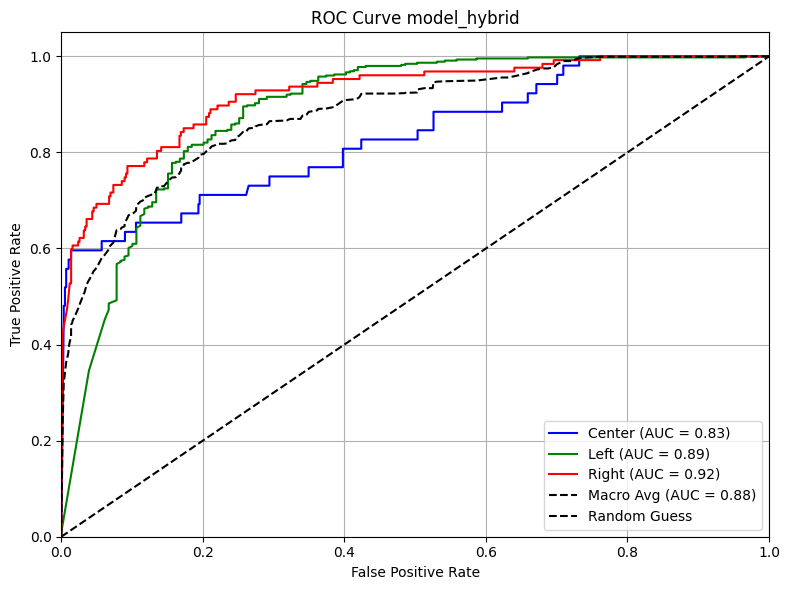

In [ ]:
# Average the predicted probabilities across the models
# y_pred_soft_probs = np.mean([prediction[m] for m in prediction], axis=0)

# Now, plot the ROC curve using those averaged probabilities
for model_name, predict in prediction.items():
  plot_roc_curve(y_test, predict, title=f"ROC Curve {model_name}")


In [ ]:
print(f"Soft Voting acc: {accuracy_score(ensemble_pred['soft_voting'], y_test)}")
print(f"Hard Voting acc: {accuracy_score(ensemble_pred['hard_voting'], y_test)}")

Soft Voting acc: 0.834920634920635
Hard Voting acc: 0.8333333333333334


In [ ]:
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 400, 100)       │     3,991,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 400, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 400, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,202,775 (50.36 MB)

 Trainable params: 4,400,839 (16.79 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 8,801,680 (33.58 MB)

In [ ]:
model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 400, 100)       │     3,991,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 400, 256)       │       176,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 400, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,907,095 (49.24 MB)

 Trainable params: 4,302,279 (16.41 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 8,604,560 (32.82 MB)

In [ ]:
model_hybrid.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 400, 100)       │     3,991,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 400, 256)       │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 400, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,080,663 (49.90 MB)

 Trainable params: 4,360,135 (16.63 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 8,720,272 (33.27 MB)